In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
#     torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

In [5]:
encoder = Inf_network(kwargs=args).to(args.device)
target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
for p in transitions.parameters():
    transitions.requires_grad_(False)
params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=1e-4)

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/400 [00:00<?, ?it/s]

On batch number 1/500 and on k = 1 we have for  0: 0.5599999874830246 and for +1: 0.4399999901652336
On batch number 1/500 and on k = 2 we have for  0: 0.5299999881535769 and for +1: 0.46999998949468136
On batch number 101/500 and on k = 1 we have for  0: 0.0 and for +1: 0.9999999776482582
On batch number 101/500 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 201/500 and on k = 1 we have for  0: 0.0 and for +1: 0.9999999776482582
On batch number 201/500 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 301/500 and on k = 1 we have for  0: 0.0 and for +1: 0.9999999776482582
On batch number 301/500 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
On batch number 401/500 and on k = 1 we have for  0: 0.0 and for +1: 0.9999999776482582
On batch number 401/500 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0
Current epoch: 1 	 Current ELBO: -5943305950986240.0
Saved samples to ./pics/mnist_epoch_0_K_

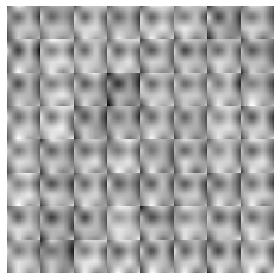

  0%|          | 1/400 [00:58<6:31:12, 58.83s/it]

On batch number 1/500 and on k = 1 we have for  0: 0.0 and for +1: 0.9999999776482582
On batch number 1/500 and on k = 2 we have for  0: 0.9999999776482582 and for +1: 0.0


KeyboardInterrupt: 

In [8]:
print_info_ = 1

torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)


def compute_loss(z, p, y, p_old, x, sum_log_alpha, sum_log_jacobian, sum_log_sigma):
    log_p = target.get_logdensity(z=z, x=x) + args.std_normal.log_prob(p).sum(1)
    log_r = -args.K * torch_log_2
    log_m = args.std_normal.log_prob(y).sum(1) - sum_log_sigma + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    current_grad = torch.mean(log_p + (sum_log_alpha + args.std_normal.log_prob(y).sum(1) + 
                                       args.std_normal.log_prob(p_old).sum(1) - sum_log_sigma) * (elbo_full.detach() - 1.))
    return elbo_full, current_grad
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        y = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * y # reperametrization trick
        p_old = args.std_normal.sample(mu.shape)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        p_old = p_old.detach()
        p = p_old
        z = z.detach()
        sum_grad = -sum_log_sigma + args.std_normal.log_prob(y).sum(1) + args.std_normal.log_prob(p_old).sum(1)
        
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            z = z.detach()
            p = p.detach()
            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        dataset.train.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            
            sum_log_alpha += current_log_alphas
            sum_log_jacobian += log_jac
            
        elbo_full, current_grad = compute_loss(z=z, p=p, y=y, p_old=p_old,
                                        x=batch_train, sum_log_alpha=sum_log_alpha, sum_log_jacobian=sum_log_jacobian, sum_log_sigma=sum_log_sigma)
        sum_grad = torch.mean(sum_grad + current_grad)
        (-sum_grad).backward()
        optimizer.step()
        optimizer.zero_grad()
        # Bias squared
    if ep % print_info_ == 0:
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)